In [1]:
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.scheduler.surveys import BaseSurvey, BlobSurvey
from rubin_scheduler.scheduler.utils import ObservationArray, SkyAreaGenerator, Footprint
from rubin_scheduler.scheduler.schedulers import CoreScheduler, SimpleFilterSched
from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.detailers import BaseDetailer
from rubin_scheduler.utils import (_approx_ra_dec2_alt_az, _approx_altaz2pa, 
                                   rotation_converter, SysEngVals, _approx_alt_az2_ra_dec,
                                  _ra_dec2_hpid)
import rubin_scheduler.scheduler.basis_functions as bf

import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd


In [2]:
# Load up a model observatory
nside=32
mo = ModelObservatory(downtimes="ideal")

In [3]:
# generate a survey footprint
sag = SkyAreaGenerator()
sky_maps, labels = sag.return_maps()

fp = Footprint(mo.mjd_start, mo.sun_ra_start)
fp.set_footprint('r', sky_maps['r'])


In [4]:
# Make a simple survey that executes blobs in r band
footprint_weight = 1.
m5_weight = 0.5

# Observe in the footprint
red_fp_basis = bf.FootprintBasisFunction(filtername='r', footprint=fp, nside=nside)
# Observe where the depth is reasonable
m5_basis_r = bf.M5DiffBasisFunction(filtername='r', nside=nside)
# Stop observing in twilight time
twilight_limit = bf.TimeToTwilightBasisFunction()
# Avoid high sun altitudes
sun_alt_limit = bf.SunAltLimitBasisFunction(alt_limit=-16.)
# Avoid the altitude limits
shadow_mask = bf.AltAzShadowMaskBasisFunction()
# Put it all together in a survey object
red_survey = BlobSurvey([red_fp_basis, m5_basis_r, twilight_limit, shadow_mask, sun_alt_limit],
                        [footprint_weight, m5_weight, 0., 0., 0.],
                        filtername1='r', survey_name='r_blob')



In [5]:
# Class to execute in twilight and take flats
class InTwilightFlatsSurvey(BaseSurvey):
    def __init__(self, basis_functions,  altitude=80., az_rel_sun=180., **kwargs,):
        super().__init__(basis_functions, **kwargs)
        self.altitude = np.radians(altitude)
        self.az_rel_sun = np.radians(az_rel_sun)
        
    def generate_observations_rough(self, conditions):
        
        if not self.reward_checked:
            self.reward = self.calc_reward_function(conditions)
        obs = ObservationArray()

        # Find good ra,dec given the latest conditions
        az = (conditions.sun_az + self.az_rel_sun) % (2 * np.pi)
        ra,dec = _approx_alt_az2_ra_dec([self.altitude], [az], conditions.site.latitude_rad, conditions.site.longitude_rad, conditions.mjd)
        
        obs["RA"] = ra
        obs["dec"] = dec
        obs["exptime"] = 30.  # Place holder exposure time, expect to clobber later
        obs["filter"] = "r"  # Can think about filter distribution later

        return [obs]
        

In [6]:
class FlatExptimeDetailer(BaseDetailer):
    """Adjust exposure time to try to reach a target number of background counts
    """
    def __init__(self, sky_counts_desired=10000, max_exptime=120, zeropoints=None, pix_scale=0.2):
        super().__init__()
        self.sky_counts_desired = sky_counts_desired
        self.max_exptime = max_exptime
        self.pix_scale = pix_scale
        if zeropoints is None:
            syv = SysEngVals()
            self.zeropoints = syv.zp_t
        else:
            self.zeropoints = zeropoints
    
    def __call__(self, observation_list, conditions):
        for obs in observation_list:
            # look up the closest HEALpix ID
            hpid = _ra_dec2_hpid(conditions.nside, obs["RA"], obs["dec"])
            mu = conditions.skybrightness[obs["filter"][0]][hpid]
            # XXX--triple check here. The zeropoints from SysEngVals
            # might already be assuming a 30s exposure. 
            counts = self.pix_scale**2 * 10.**((self.zeropoints[obs["filter"][0]] - mu)/2.5)
            time_needed = np.max(self.sky_counts_desired / counts)
            obs["exptime"] = np.min([time_needed, self.max_exptime])
        
        return observation_list

In [7]:

detailers = [FlatExptimeDetailer()]
flat_survey = InTwilightFlatsSurvey([], detailers=detailers)

In [8]:
scheduler = CoreScheduler([[red_survey], [flat_survey]], nside=nside)

In [9]:
# Simulate running the scheduler in this configuration for a few days
mo, scheduler, observations = sim_runner(mo, scheduler, sim_duration=3.0, verbose=True)


/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/model_observatory/kinem_model.py:755: RuntimeWarning: divide by zero encountered in divide
  (observation["exptime"] / observation["nexp"] + self.readtime * (observation["nexp"] - 1))
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/model_observatory/kinem_model.py:743: RuntimeWarning: divide by zero encountered in divide
  delta_t = observation["exptime"] / observation["nexp"]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/model_observatory/model_observatory.py:524: RuntimeWarning: divide by zero encountered in divide
  observation["exptime"] / observation["nexp"],


progress = 1.40%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:339: RuntimeWarning: All-NaN slice encountered
  indx = np.where(in_map[current_neighbors] == np.nanmax(in_map[current_neighbors]))[0]
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/utils/healpy_utils.py:342: UserWarning: Can not connect to any more pixels.
  warnings.warn("Can not connect to any more pixels.")


progress = 33.35%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 100.07%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1402 observations
ran in 0 min = 0.0 hours


In [10]:
# Can see what observations got executed
observations

ObservationArray([(   0, 5.9341817 , -0.44801498, 60980.00089649, 0.,  40.99873428, 'r', 2.62654662, 0., 0, 1.01542661, 0.97896171, 1.18992172, 1.03011566, 18.91556575, 0, 43.48426793,  40.99873428, 0.15882974, inf, 1.39061373, 1.14140062, 4.1978007 , -2.08438651, 0.,  1.17998259, -0.2119851 , '', '', '', 0, 22.00737099, 0.00145585, 0., 0.41668499, 4.27814565, 3.77138619, -0.24996749, 5.91222818, -0.16783961, 0.28094872, 1.9607675 , 65.72719529, 1.13841547, '', ''),
                  (   1, 5.93999762, -0.44746821, 60980.00141658, 0.,  42.31439979, 'r', 2.62312922, 0., 0, 1.01542661, 0.97896171, 1.18992172, 1.03011566, 18.9338063 , 0,  3.93626399,  42.31439979, 0.00527105, inf, 1.3883522 , 1.14495788, 4.20020876, -2.08199389, 0.,  1.18099019, -0.21456703, '', '', '', 0, 22.0198871 , 0.00726587, 0., 0.40927222, 4.27621742, 3.77139506, -0.24997041, 5.91229311, -0.16778402, 0.2809172 , 1.96558292, 65.72946016, 1.1509492 , '', ''),
                  (   2, 5.9431802 , -0.4471685 , 60980.00

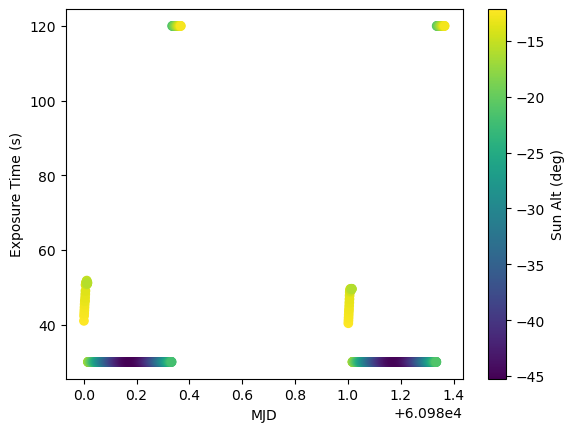

In [11]:
plt.scatter(observations["mjd"], observations["exptime"], c=np.degrees(observations["sunAlt"]))
cb = plt.colorbar()
plt.xlabel('MJD')
plt.ylabel('Exposure Time (s)')
cb.set_label('Sun Alt (deg)')